# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behaviour, get_revenue_behaviour_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
RU2                     4
RU3                    10
RU1                     6
RU4                     5
Total                  25


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  25


/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


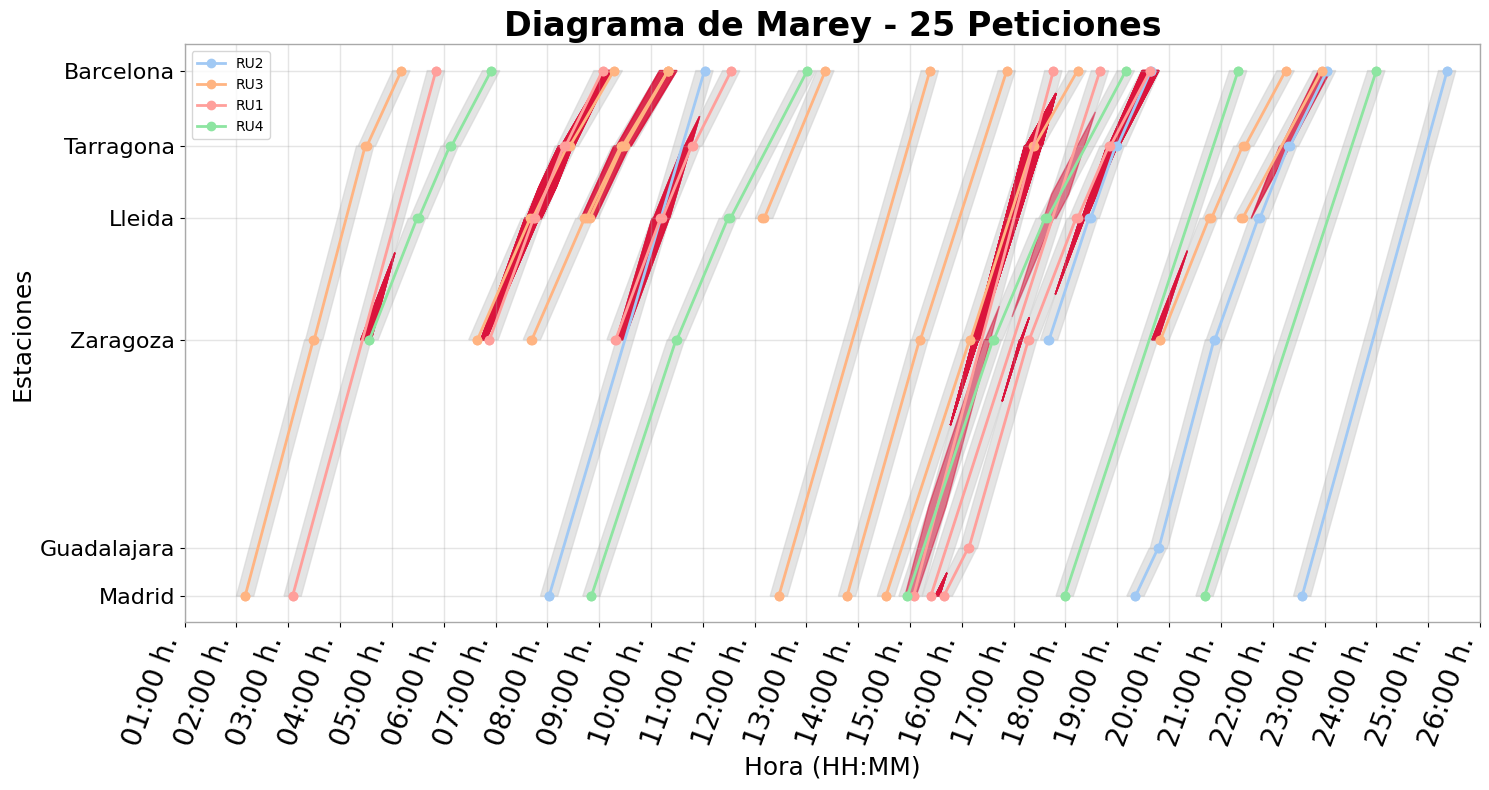

In [6]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - 25 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [10]:
from src.timetabling_problem import MPTT

mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

In [11]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {"Genetic Algorithm": GA.BaseGA,
            "Particle Swarm Optimization": PSO.OriginalPSO,
            "Simulated Annealing": SA.OriginalSA,
            "Differential Evolution": DE.OriginalDE,
            "Ant Colony Optimization Continuous (ACOR)": ACOR.OriginalACOR,
            "Covariance Matrix Adaptation Evolution Strategy": ES.CMA_ES,
            "Artificial Bee Colony": ABC.OriginalABC,
            "Grey Wolf Optimizer": GWO.OriginalGWO,
            "Whale Optimization Algorithm": WOA.OriginalWOA,
            "Hybrid Grey Wolf - Whale Optimization Algorithm": GWO.GWO_WOA}

In [12]:
from mealpy import IntegerVar

runs = 5
epochs = 100
pop_size = 50

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {"obj_func": mptt.objective_function,
           "bounds": IntegerVar(lb=lb,
                              ub=ub),
           "minmax": "max",
           "save_population": True}

# 1. Iter algorithms
df_history = pd.DataFrame()
df_population = pd.DataFrame()

for algo_name, algo in mp_algos.items():
    print(f"Running {algo_name}")
    for r in range(1, runs+1):
        print("\tRun: ", r)
        
        # Run algorithm
        if algo_name == "Simulated Annealing":
            optimizer = algo(epoch=epochs*pop_size)
            optimizer.solve(problem)
        else:
            optimizer = algo(epoch=epochs, pop_size=pop_size)
            optimizer.solve(problem)
            
        # Build run history dataframe
        columns = ['Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real', 
                   'Diversity', 'Exploitation', 'Exploration']
        run_history = pd.DataFrame(columns=columns)
        
        # Save optimizer history to dataframe
        for i, data in enumerate(optimizer.history.list_global_best):
            mptt.update_schedule(data.solution)
            run_history.loc[i] = [algo_name,
                                  i, 
                                  data.target.fitness,
                                  optimizer.history.list_epoch_time[i],
                                  mptt.get_heuristic_schedule(),
                                  data.solution,
                                  optimizer.history.list_diversity[i],
                                  optimizer.history.list_exploitation[i],
                                  optimizer.history.list_exploration[i]]
    
        run_history.insert(0, "Run", r)
        df_history = pd.concat([df_history, run_history], axis=0)
        
        # Population dataframe
        if algo_name == "Simulated Annealing":
            continue
        
        population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
        population_colums.insert(0, 'Iteration')
        run_population = pd.DataFrame(columns=population_colums)
        
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_row = [i]
            real = []
            discrete = [] 
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real.append(individual.solution)
                discrete.append(mptt.get_heuristic_schedule())
            
            population_row = [i, *real, *discrete]
            run_population.loc[len(run_population)] = population_row
        
        run_population.insert(0, "Run", r)
        run_population.insert(1, "Algo", algo_name)
        df_population = pd.concat([df_population, run_population], axis=0)    

2024/11/27 10:40:54 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Genetic Algorithm
	Run:  1


2024/11/27 10:40:54 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2612.505760382095, Global best: 2612.505760382095, Runtime: 0.26470 seconds
2024/11/27 10:40:54 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2857.3935776208396, Global best: 2857.3935776208396, Runtime: 0.24339 seconds
2024/11/27 10:40:55 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2923.807402762704, Global best: 2923.807402762704, Runtime: 0.23911 seconds
2024/11/27 10:40:55 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3163.8025366022116, Global best: 3163.8025366022116, Runtime: 0.24619 seconds
2024/11/27 10:40:55 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3274.704363088659, Global best: 3274.704363088659, Runtime: 0.24173 seconds
2024/11/27 10:40:55 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

	Run:  2


2024/11/27 10:41:39 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2329.056616387078, Global best: 2329.056616387078, Runtime: 0.23982 seconds
2024/11/27 10:41:40 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2369.3996712211288, Global best: 2369.3996712211288, Runtime: 0.24806 seconds
2024/11/27 10:41:40 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2567.864624539063, Global best: 2567.864624539063, Runtime: 0.24261 seconds
2024/11/27 10:41:40 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2774.0334803429455, Global best: 2774.0334803429455, Runtime: 0.23912 seconds
2024/11/27 10:41:40 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3094.3175287879503, Global best: 3094.3175287879503, Runtime: 0.23731 seconds
2024/11/27 10:41:41 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run:  3


2024/11/27 10:42:25 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2230.240150551889, Global best: 2230.240150551889, Runtime: 0.25029 seconds
2024/11/27 10:42:25 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2459.4719483547965, Global best: 2459.4719483547965, Runtime: 0.24788 seconds
2024/11/27 10:42:26 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2893.624564029121, Global best: 2893.624564029121, Runtime: 0.24499 seconds
2024/11/27 10:42:26 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2941.2452303204777, Global best: 2941.2452303204777, Runtime: 0.25642 seconds
2024/11/27 10:42:26 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3241.9465547922487, Global best: 3241.9465547922487, Runtime: 0.24778 seconds
2024/11/27 10:42:26 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run:  4


2024/11/27 10:43:11 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2491.0544001068474, Global best: 2491.0544001068474, Runtime: 0.24198 seconds
2024/11/27 10:43:11 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3039.7642195961594, Global best: 3039.7642195961594, Runtime: 0.24568 seconds
2024/11/27 10:43:11 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2859.600022285774, Global best: 3039.7642195961594, Runtime: 0.24564 seconds
2024/11/27 10:43:11 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3385.565623588706, Global best: 3385.565623588706, Runtime: 0.24345 seconds
2024/11/27 10:43:12 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3416.5831520603992, Global best: 3416.5831520603992, Runtime: 0.24680 seconds
2024/11/27 10:43:12 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, E

	Run:  5


2024/11/27 10:43:56 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2493.893754697274, Global best: 2493.893754697274, Runtime: 0.24457 seconds
2024/11/27 10:43:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2652.153747624742, Global best: 2652.153747624742, Runtime: 0.25012 seconds
2024/11/27 10:43:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3096.6780704990942, Global best: 3096.6780704990942, Runtime: 0.24819 seconds
2024/11/27 10:43:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3388.3203371610593, Global best: 3388.3203371610593, Runtime: 0.24662 seconds
2024/11/27 10:43:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3388.3203371610593, Global best: 3388.3203371610593, Runtime: 0.24522 seconds
2024/11/27 10:43:58 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

Running Particle Swarm Optimization
	Run:  1


2024/11/27 10:44:42 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2395.6782302255688, Global best: 2395.6782302255688, Runtime: 0.24068 seconds
2024/11/27 10:44:43 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2899.1204615945944, Global best: 2899.1204615945944, Runtime: 0.24454 seconds
2024/11/27 10:44:43 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2899.1204615945944, Global best: 2899.1204615945944, Runtime: 0.24219 seconds
2024/11/27 10:44:43 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2899.1204615945944, Global best: 2899.1204615945944, Runtime: 0.24141 seconds
2024/11/27 10:44:43 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2899.1204615945944, Global best: 2899.1204615945944, Runtime: 0.24208 seconds
2024/11/27 10:44:44 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoc

	Run:  2


2024/11/27 10:45:28 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2289.1947524403877, Global best: 2289.1947524403877, Runtime: 0.23966 seconds
2024/11/27 10:45:28 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2835.475220541998, Global best: 2835.475220541998, Runtime: 0.24332 seconds
2024/11/27 10:45:28 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2835.475220541998, Global best: 2835.475220541998, Runtime: 0.24285 seconds
2024/11/27 10:45:29 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2835.475220541998, Global best: 2835.475220541998, Runtime: 0.24206 seconds
2024/11/27 10:45:29 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2835.475220541998, Global best: 2835.475220541998, Runtime: 0.24448 seconds
2024/11/27 10:45:29 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, Cu

	Run:  3


2024/11/27 10:46:14 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2326.4528676937553, Global best: 2326.4528676937553, Runtime: 0.24400 seconds
2024/11/27 10:46:14 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2997.4593569548724, Global best: 2997.4593569548724, Runtime: 0.25391 seconds
2024/11/27 10:46:14 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 3117.723102783905, Global best: 3117.723102783905, Runtime: 0.24992 seconds
2024/11/27 10:46:14 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 3117.723102783905, Global best: 3117.723102783905, Runtime: 0.24562 seconds
2024/11/27 10:46:15 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 3117.723102783905, Global best: 3117.723102783905, Runtime: 0.24791 seconds
2024/11/27 10:46:15 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, 

	Run:  4


2024/11/27 10:47:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2275.22646070468, Global best: 2275.22646070468, Runtime: 0.24320 seconds
2024/11/27 10:47:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2467.2889059157073, Global best: 2467.2889059157073, Runtime: 0.24293 seconds
2024/11/27 10:47:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2508.5320060603235, Global best: 2508.5320060603235, Runtime: 0.24310 seconds
2024/11/27 10:47:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2685.011389086283, Global best: 2685.011389086283, Runtime: 0.24368 seconds
2024/11/27 10:47:01 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2878.1420142816, Global best: 2878.1420142816, Runtime: 0.24688 seconds
2024/11/27 10:47:01 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, Curren

	Run:  5


2024/11/27 10:47:45 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2513.510093084211, Global best: 2513.510093084211, Runtime: 0.23961 seconds
2024/11/27 10:47:46 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2513.510093084211, Global best: 2513.510093084211, Runtime: 0.24513 seconds
2024/11/27 10:47:46 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2601.784153355029, Global best: 2601.784153355029, Runtime: 0.24336 seconds
2024/11/27 10:47:46 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2601.784153355029, Global best: 2601.784153355029, Runtime: 0.24128 seconds
2024/11/27 10:47:46 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2601.784153355029, Global best: 2601.784153355029, Runtime: 0.24402 seconds
2024/11/27 10:47:46 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, Curr

Running Simulated Annealing
	Run:  1


2024/11/27 10:48:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1915.3371327767604, Global best: 1915.3371327767604, Runtime: 0.00519 seconds
2024/11/27 10:48:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1915.3371327767604, Global best: 1915.3371327767604, Runtime: 0.00506 seconds
2024/11/27 10:48:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 1915.3371327767604, Global best: 1915.3371327767604, Runtime: 0.00534 seconds
2024/11/27 10:48:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 37, Current best: 1915.3371327767604, Global best: 1915.3371327767604, Runtime: 0.00514 seconds
2024/11/27 10:48:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 38, Current best: 1915.3371327767604, Global best: 1915.3371327767604, Runtime: 0.00535 seconds
2024/11/27 10:48:31 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  2


2024/11/27 10:49:21 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1597.5479845374336, Global best: 1597.5479845374336, Runtime: 0.00544 seconds
2024/11/27 10:49:21 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1597.5479845374336, Global best: 1597.5479845374336, Runtime: 0.00564 seconds
2024/11/27 10:49:21 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 1597.5479845374336, Global best: 1597.5479845374336, Runtime: 0.00537 seconds
2024/11/27 10:49:21 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 37, Current best: 1597.5479845374336, Global best: 1597.5479845374336, Runtime: 0.00549 seconds
2024/11/27 10:49:21 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 38, Current best: 1597.5479845374336, Global best: 1597.5479845374336, Runtime: 0.00521 seconds
2024/11/27 10:49:21 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  3


2024/11/27 10:50:12 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1935.3506975509113, Global best: 1935.3506975509113, Runtime: 0.00505 seconds
2024/11/27 10:50:12 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1935.3506975509113, Global best: 1935.3506975509113, Runtime: 0.00521 seconds
2024/11/27 10:50:12 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 1935.3506975509113, Global best: 1935.3506975509113, Runtime: 0.00532 seconds
2024/11/27 10:50:12 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 37, Current best: 1935.3506975509113, Global best: 1935.3506975509113, Runtime: 0.00540 seconds
2024/11/27 10:50:12 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 38, Current best: 1935.3506975509113, Global best: 1935.3506975509113, Runtime: 0.00504 seconds
2024/11/27 10:50:12 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  4


2024/11/27 10:51:03 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1708.6584157126508, Global best: 1708.6584157126508, Runtime: 0.00500 seconds
2024/11/27 10:51:03 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1708.6584157126508, Global best: 1708.6584157126508, Runtime: 0.00508 seconds
2024/11/27 10:51:03 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 1708.6584157126508, Global best: 1708.6584157126508, Runtime: 0.00520 seconds
2024/11/27 10:51:03 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 37, Current best: 1708.6584157126508, Global best: 1708.6584157126508, Runtime: 0.00544 seconds
2024/11/27 10:51:03 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 38, Current best: 1708.6584157126508, Global best: 1708.6584157126508, Runtime: 0.00531 seconds
2024/11/27 10:51:03 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  5


2024/11/27 10:51:54 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 33, Current best: 1924.3447423746682, Global best: 1924.3447423746682, Runtime: 0.00496 seconds
2024/11/27 10:51:54 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1924.3447423746682, Global best: 1924.3447423746682, Runtime: 0.00502 seconds
2024/11/27 10:51:54 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1924.3447423746682, Global best: 1924.3447423746682, Runtime: 0.00519 seconds
2024/11/27 10:51:54 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 1924.3447423746682, Global best: 1924.3447423746682, Runtime: 0.00524 seconds
2024/11/27 10:51:54 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 37, Current best: 1924.3447423746682, Global best: 1924.3447423746682, Runtime: 0.00517 seconds
2024/11/27 10:51:54 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

Running Differential Evolution
	Run:  1


2024/11/27 10:52:45 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2461.469372083314, Global best: 2461.469372083314, Runtime: 0.24274 seconds
2024/11/27 10:52:45 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2461.469372083314, Global best: 2461.469372083314, Runtime: 0.24932 seconds
2024/11/27 10:52:45 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2649.437003389836, Global best: 2649.437003389836, Runtime: 0.24648 seconds
2024/11/27 10:52:46 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2649.437003389836, Global best: 2649.437003389836, Runtime: 0.24536 seconds
2024/11/27 10:52:46 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2649.437003389836, Global best: 2649.437003389836, Runtime: 0.24575 seconds
2024/11/27 10:52:46 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE:

	Run:  2


2024/11/27 10:53:31 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2485.135723915105, Global best: 2485.135723915105, Runtime: 0.24890 seconds
2024/11/27 10:53:32 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2485.135723915105, Global best: 2485.135723915105, Runtime: 0.24459 seconds
2024/11/27 10:53:32 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2509.4548697302184, Global best: 2509.4548697302184, Runtime: 0.24814 seconds
2024/11/27 10:53:32 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2783.994579212675, Global best: 2783.994579212675, Runtime: 0.24842 seconds
2024/11/27 10:53:32 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 6, Current best: 2876.4800072062544, Global best: 2876.4800072062544, Runtime: 0.24940 seconds
2024/11/27 10:53:33 AM, INFO, mealpy.evolutionary_based.DE.Origina

	Run:  3


2024/11/27 10:54:18 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2190.605700117474, Global best: 2190.605700117474, Runtime: 0.24321 seconds
2024/11/27 10:54:18 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2594.3056125976937, Global best: 2594.3056125976937, Runtime: 0.24827 seconds
2024/11/27 10:54:18 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2594.3056125976937, Global best: 2594.3056125976937, Runtime: 0.24619 seconds
2024/11/27 10:54:19 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2594.3056125976937, Global best: 2594.3056125976937, Runtime: 0.25401 seconds
2024/11/27 10:54:19 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2594.3056125976937, Global best: 2594.3056125976937, Runtime: 0.24792 seconds
2024/11/27 10:54:19 AM, INFO, mealpy.evolutionary_based.DE.Ori

	Run:  4


2024/11/27 10:55:04 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2073.024614001126, Global best: 2073.024614001126, Runtime: 0.24893 seconds
2024/11/27 10:55:04 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2184.895809924622, Global best: 2184.895809924622, Runtime: 0.25419 seconds
2024/11/27 10:55:04 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2475.5887525100675, Global best: 2475.5887525100675, Runtime: 0.24541 seconds
2024/11/27 10:55:04 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2475.5887525100675, Global best: 2475.5887525100675, Runtime: 0.24542 seconds
2024/11/27 10:55:05 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2478.007174608269, Global best: 2478.007174608269, Runtime: 0.24679 seconds
2024/11/27 10:55:05 AM, INFO, mealpy.evolutionary_based.DE.Origina

	Run:  5


2024/11/27 10:55:50 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2223.3569390290245, Global best: 2223.3569390290245, Runtime: 0.24324 seconds
2024/11/27 10:55:51 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2228.120444738804, Global best: 2228.120444738804, Runtime: 0.24788 seconds
2024/11/27 10:55:51 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2504.770871496541, Global best: 2504.770871496541, Runtime: 0.24732 seconds
2024/11/27 10:55:51 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2504.770871496541, Global best: 2504.770871496541, Runtime: 0.24490 seconds
2024/11/27 10:55:51 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2524.0059025084256, Global best: 2524.0059025084256, Runtime: 0.24343 seconds
2024/11/27 10:55:52 AM, INFO, mealpy.evolutionary_based.DE.Origina

Running Ant Colony Optimization Continuous (ACOR)
	Run:  1


2024/11/27 10:56:36 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 1999.8404734295832, Global best: 1999.8404734295832, Runtime: 0.14936 seconds
2024/11/27 10:56:36 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2465.8237000228705, Global best: 2465.8237000228705, Runtime: 0.14677 seconds
2024/11/27 10:56:37 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2465.8237000228705, Global best: 2465.8237000228705, Runtime: 0.15109 seconds
2024/11/27 10:56:37 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2465.8237000228705, Global best: 2465.8237000228705, Runtime: 0.15039 seconds
2024/11/27 10:56:37 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2465.8237000228705, Global best: 2465.8237000228705, Runtime: 0.15057 seconds
2024/11/27 10:56:37 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

	Run:  2


2024/11/27 10:57:12 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2351.279400074084, Global best: 2351.279400074084, Runtime: 0.14833 seconds
2024/11/27 10:57:13 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2360.6898060954995, Global best: 2360.6898060954995, Runtime: 0.15345 seconds
2024/11/27 10:57:13 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2360.6898060954995, Global best: 2360.6898060954995, Runtime: 0.15119 seconds
2024/11/27 10:57:13 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2360.6898060954995, Global best: 2360.6898060954995, Runtime: 0.15341 seconds
2024/11/27 10:57:13 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2360.6898060954995, Global best: 2360.6898060954995, Runtime: 0.14853 seconds
2024/11/27 10:57:13 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Proble

	Run:  3


2024/11/27 10:57:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2201.5028798839294, Global best: 2201.5028798839294, Runtime: 0.14869 seconds
2024/11/27 10:57:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2225.6708603240522, Global best: 2225.6708603240522, Runtime: 0.14523 seconds
2024/11/27 10:57:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2454.5922744055615, Global best: 2454.5922744055615, Runtime: 0.15028 seconds
2024/11/27 10:57:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2454.5922744055615, Global best: 2454.5922744055615, Runtime: 0.14568 seconds
2024/11/27 10:57:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2457.7462638606353, Global best: 2457.7462638606353, Runtime: 0.15199 seconds
2024/11/27 10:57:50 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

	Run:  4


2024/11/27 10:58:25 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2267.3165405765053, Global best: 2267.3165405765053, Runtime: 0.15344 seconds
2024/11/27 10:58:25 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2267.3165405765053, Global best: 2267.3165405765053, Runtime: 0.14652 seconds
2024/11/27 10:58:25 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2267.3165405765053, Global best: 2267.3165405765053, Runtime: 0.15002 seconds
2024/11/27 10:58:26 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2304.814654112309, Global best: 2304.814654112309, Runtime: 0.15012 seconds
2024/11/27 10:58:26 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2304.814654112309, Global best: 2304.814654112309, Runtime: 0.14796 seconds
2024/11/27 10:58:26 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem:

	Run:  5


2024/11/27 10:59:01 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2055.542610750523, Global best: 2055.542610750523, Runtime: 0.14937 seconds
2024/11/27 10:59:01 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2055.542610750523, Global best: 2055.542610750523, Runtime: 0.14606 seconds
2024/11/27 10:59:02 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2363.3273329401504, Global best: 2363.3273329401504, Runtime: 0.14572 seconds
2024/11/27 10:59:02 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2363.3273329401504, Global best: 2363.3273329401504, Runtime: 0.14773 seconds
2024/11/27 10:59:02 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2363.3273329401504, Global best: 2363.3273329401504, Runtime: 0.14969 seconds
2024/11/27 10:59:02 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem:

Running Covariance Matrix Adaptation Evolution Strategy
	Run:  1


2024/11/27 10:59:38 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2815.8087003713517, Global best: 2815.8087003713517, Runtime: 0.50708 seconds
2024/11/27 10:59:39 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2658.5039126982715, Global best: 2815.8087003713517, Runtime: 0.44298 seconds
2024/11/27 10:59:39 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3282.2554767148868, Global best: 3282.2554767148868, Runtime: 0.45246 seconds
2024/11/27 10:59:40 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2935.276402538301, Global best: 3282.2554767148868, Runtime: 0.54916 seconds
2024/11/27 10:59:40 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2940.7710641910235, Global best: 3282.2554767148868, Runtime: 0.54036 seconds
2024/11/27 10:59:41 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P,

	Run:  2


2024/11/27 11:00:49 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2798.55945677815, Global best: 2798.55945677815, Runtime: 0.38051 seconds
2024/11/27 11:00:49 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2794.0530785670085, Global best: 2798.55945677815, Runtime: 0.43471 seconds
2024/11/27 11:00:49 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 2756.767320597444, Global best: 2798.55945677815, Runtime: 0.43830 seconds
2024/11/27 11:00:50 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2746.147468626485, Global best: 2798.55945677815, Runtime: 0.52338 seconds
2024/11/27 11:00:50 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2630.373974743951, Global best: 2798.55945677815, Runtime: 0.45376 seconds
2024/11/27 11:00:51 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 6, Cur

	Run:  3


2024/11/27 11:01:58 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2740.7258447338327, Global best: 2740.7258447338327, Runtime: 0.39682 seconds
2024/11/27 11:01:58 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2898.5854141707705, Global best: 2898.5854141707705, Runtime: 0.43580 seconds
2024/11/27 11:01:59 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3020.887670312141, Global best: 3020.887670312141, Runtime: 0.45971 seconds
2024/11/27 11:01:59 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2762.825975404556, Global best: 3020.887670312141, Runtime: 0.52651 seconds
2024/11/27 11:02:00 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2713.0871060427194, Global best: 3020.887670312141, Runtime: 0.48465 seconds
2024/11/27 11:02:00 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epo

	Run:  4


2024/11/27 11:03:10 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2938.0976949931487, Global best: 2938.0976949931487, Runtime: 0.41813 seconds
2024/11/27 11:03:11 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2708.8902732067495, Global best: 2938.0976949931487, Runtime: 0.46516 seconds
2024/11/27 11:03:11 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3032.8159673835403, Global best: 3032.8159673835403, Runtime: 0.46506 seconds
2024/11/27 11:03:12 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2722.2785351521306, Global best: 3032.8159673835403, Runtime: 0.47579 seconds
2024/11/27 11:03:12 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2937.4254845056166, Global best: 3032.8159673835403, Runtime: 0.55553 seconds
2024/11/27 11:03:13 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P

	Run:  5


2024/11/27 11:04:21 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2746.536370773786, Global best: 2746.536370773786, Runtime: 0.39492 seconds
2024/11/27 11:04:21 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2905.4662005954133, Global best: 2905.4662005954133, Runtime: 0.42193 seconds
2024/11/27 11:04:21 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 2572.1754668088415, Global best: 2905.4662005954133, Runtime: 0.44178 seconds
2024/11/27 11:04:22 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2694.658334667488, Global best: 2905.4662005954133, Runtime: 0.39369 seconds
2024/11/27 11:04:22 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2875.1041296546664, Global best: 2905.4662005954133, Runtime: 0.43144 seconds
2024/11/27 11:04:23 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, E

Running Artificial Bee Colony
	Run:  1


2024/11/27 11:05:30 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2327.4327699523596, Global best: 2327.4327699523596, Runtime: 0.49365 seconds
2024/11/27 11:05:30 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2327.4327699523596, Global best: 2327.4327699523596, Runtime: 0.50679 seconds
2024/11/27 11:05:31 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2536.8467902132506, Global best: 2536.8467902132506, Runtime: 0.51729 seconds
2024/11/27 11:05:31 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2536.8467902132506, Global best: 2536.8467902132506, Runtime: 0.49447 seconds
2024/11/27 11:05:32 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2536.8467902132506, Global best: 2536.8467902132506, Runtime: 0.49013 seconds
2024/11/27 11:05:32 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoc

	Run:  2


2024/11/27 11:06:41 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2131.32393597113, Global best: 2131.32393597113, Runtime: 0.48713 seconds
2024/11/27 11:06:41 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2158.5145666241415, Global best: 2158.5145666241415, Runtime: 0.51440 seconds
2024/11/27 11:06:42 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2245.1576936708034, Global best: 2245.1576936708034, Runtime: 0.48837 seconds
2024/11/27 11:06:42 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2379.317179952326, Global best: 2379.317179952326, Runtime: 0.48896 seconds
2024/11/27 11:06:43 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2539.773876775876, Global best: 2539.773876775876, Runtime: 0.48725 seconds
2024/11/27 11:06:43 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6, Cu

	Run:  3


2024/11/27 11:07:52 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2572.769985850714, Global best: 2572.769985850714, Runtime: 0.48484 seconds
2024/11/27 11:07:52 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2572.769985850714, Global best: 2572.769985850714, Runtime: 0.48816 seconds
2024/11/27 11:07:53 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2572.769985850714, Global best: 2572.769985850714, Runtime: 0.48437 seconds
2024/11/27 11:07:53 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2572.769985850714, Global best: 2572.769985850714, Runtime: 0.48881 seconds
2024/11/27 11:07:54 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2748.282649363426, Global best: 2748.282649363426, Runtime: 0.48699 seconds
2024/11/27 11:07:54 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6, Curr

	Run:  4


2024/11/27 11:09:02 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2361.231977733205, Global best: 2361.231977733205, Runtime: 0.48326 seconds
2024/11/27 11:09:03 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2372.241291277438, Global best: 2372.241291277438, Runtime: 0.48759 seconds
2024/11/27 11:09:03 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2372.241291277438, Global best: 2372.241291277438, Runtime: 0.48700 seconds
2024/11/27 11:09:04 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2690.9923945763167, Global best: 2690.9923945763167, Runtime: 0.48814 seconds
2024/11/27 11:09:04 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2690.9923945763167, Global best: 2690.9923945763167, Runtime: 0.48606 seconds
2024/11/27 11:09:05 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6, 

	Run:  5


2024/11/27 11:10:13 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2431.7721133868063, Global best: 2431.7721133868063, Runtime: 0.49644 seconds
2024/11/27 11:10:14 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2493.4508559253663, Global best: 2493.4508559253663, Runtime: 0.49017 seconds
2024/11/27 11:10:14 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2493.4508559253663, Global best: 2493.4508559253663, Runtime: 0.49806 seconds
2024/11/27 11:10:15 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2493.4508559253663, Global best: 2493.4508559253663, Runtime: 0.48886 seconds
2024/11/27 11:10:15 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6, Current best: 2493.4508559253663, Global best: 2493.4508559253663, Runtime: 0.48418 seconds
2024/11/27 11:10:16 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoc

Running Grey Wolf Optimizer
	Run:  1


2024/11/27 11:11:24 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2140.2100787708255, Global best: 2140.2100787708255, Runtime: 0.24200 seconds
2024/11/27 11:11:24 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2140.2100787708255, Global best: 2140.2100787708255, Runtime: 0.24679 seconds
2024/11/27 11:11:24 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2170.5792097130525, Global best: 2170.5792097130525, Runtime: 0.24311 seconds
2024/11/27 11:11:25 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2378.2547948517267, Global best: 2378.2547948517267, Runtime: 0.24257 seconds
2024/11/27 11:11:25 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2461.0100962850056, Global best: 2461.0100962850056, Runtime: 0.24202 seconds
2024/11/27 11:11:25 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

	Run:  2


2024/11/27 11:12:10 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2810.7008089740307, Global best: 2810.7008089740307, Runtime: 0.24305 seconds
2024/11/27 11:12:10 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2810.7008089740307, Global best: 2810.7008089740307, Runtime: 0.24714 seconds
2024/11/27 11:12:10 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2810.7008089740307, Global best: 2810.7008089740307, Runtime: 0.24091 seconds
2024/11/27 11:12:11 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2810.7008089740307, Global best: 2810.7008089740307, Runtime: 0.24328 seconds
2024/11/27 11:12:11 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2810.7008089740307, Global best: 2810.7008089740307, Runtime: 0.25028 seconds
2024/11/27 11:12:11 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

	Run:  3


2024/11/27 11:12:56 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2148.266839657862, Global best: 2148.266839657862, Runtime: 0.24228 seconds
2024/11/27 11:12:56 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2165.597477932022, Global best: 2165.597477932022, Runtime: 0.24452 seconds
2024/11/27 11:12:56 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2191.218627852284, Global best: 2191.218627852284, Runtime: 0.24401 seconds
2024/11/27 11:12:56 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2332.7391161348487, Global best: 2332.7391161348487, Runtime: 0.24401 seconds
2024/11/27 11:12:57 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2332.7391161348487, Global best: 2332.7391161348487, Runtime: 0.24308 seconds
2024/11/27 11:12:57 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, 

	Run:  4


2024/11/27 11:13:42 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2034.2256221838875, Global best: 2034.2256221838875, Runtime: 0.24647 seconds
2024/11/27 11:13:42 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2271.8908408842376, Global best: 2271.8908408842376, Runtime: 0.24419 seconds
2024/11/27 11:13:42 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2271.8908408842376, Global best: 2271.8908408842376, Runtime: 0.24515 seconds
2024/11/27 11:13:42 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2271.8908408842376, Global best: 2271.8908408842376, Runtime: 0.24389 seconds
2024/11/27 11:13:43 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2295.3274719848737, Global best: 2295.3274719848737, Runtime: 0.24185 seconds
2024/11/27 11:13:43 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

	Run:  5


2024/11/27 11:14:27 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2255.913374756597, Global best: 2255.913374756597, Runtime: 0.25044 seconds
2024/11/27 11:14:28 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2255.913374756597, Global best: 2255.913374756597, Runtime: 0.24752 seconds
2024/11/27 11:14:28 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2255.913374756597, Global best: 2255.913374756597, Runtime: 0.24369 seconds
2024/11/27 11:14:28 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2255.913374756597, Global best: 2255.913374756597, Runtime: 0.25234 seconds
2024/11/27 11:14:28 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2255.913374756597, Global best: 2255.913374756597, Runtime: 0.24604 seconds
2024/11/27 11:14:29 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, Curr

Running Whale Optimization Algorithm
	Run:  1


2024/11/27 11:15:13 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3550.2198193174863, Global best: 3550.2198193174863, Runtime: 0.24857 seconds
2024/11/27 11:15:14 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3551.035081949588, Global best: 3551.035081949588, Runtime: 0.24862 seconds
2024/11/27 11:15:14 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3551.035081949588, Global best: 3551.035081949588, Runtime: 0.25073 seconds
2024/11/27 11:15:14 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3551.035081949588, Global best: 3551.035081949588, Runtime: 0.24791 seconds
2024/11/27 11:15:14 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Current best: 3551.035081949588, Global best: 3551.035081949588, Runtime: 0.24806 seconds
2024/11/27 11:15:15 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 7, Cu

	Run:  2


2024/11/27 11:16:00 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 3473.8771327838385, Global best: 3473.8771327838385, Runtime: 0.26138 seconds
2024/11/27 11:16:00 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3481.1296569593296, Global best: 3481.1296569593296, Runtime: 0.25513 seconds
2024/11/27 11:16:00 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3544.668550152201, Global best: 3544.668550152201, Runtime: 0.24520 seconds
2024/11/27 11:16:00 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3551.706181786793, Global best: 3551.706181786793, Runtime: 0.25484 seconds
2024/11/27 11:16:01 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3551.706181786793, Global best: 3551.706181786793, Runtime: 0.24380 seconds
2024/11/27 11:16:01 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, 

	Run:  3


2024/11/27 11:16:46 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3515.6834212458193, Global best: 3515.6834212458193, Runtime: 0.24736 seconds
2024/11/27 11:16:46 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3518.9062708730976, Global best: 3518.9062708730976, Runtime: 0.24544 seconds
2024/11/27 11:16:47 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3524.9353847874777, Global best: 3524.9353847874777, Runtime: 0.24722 seconds
2024/11/27 11:16:47 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3524.9353847874777, Global best: 3524.9353847874777, Runtime: 0.24661 seconds
2024/11/27 11:16:47 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Current best: 3524.9353847904786, Global best: 3524.9353847904786, Runtime: 0.24445 seconds
2024/11/27 11:16:47 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoc

	Run:  4


2024/11/27 11:17:32 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24507 seconds
2024/11/27 11:17:32 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24776 seconds
2024/11/27 11:17:32 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3523.551840384405, Global best: 3523.551840384405, Runtime: 0.24595 seconds
2024/11/27 11:17:33 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3523.551840384405, Global best: 3523.551840384405, Runtime: 0.24180 seconds
2024/11/27 11:17:33 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3523.551840384405, Global best: 3523.551840384405, Runtime: 0.24429 seconds
2024/11/27 11:17:33 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Curr

	Run:  5


2024/11/27 11:18:18 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24482 seconds
2024/11/27 11:18:18 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24843 seconds
2024/11/27 11:18:18 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3454.2254671516353, Global best: 3454.2254671516353, Runtime: 0.24493 seconds
2024/11/27 11:18:18 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3454.2521106461413, Global best: 3454.2521106461413, Runtime: 0.24396 seconds
2024/11/27 11:18:19 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3528.9063981544105, Global best: 3528.9063981544105, Runtime: 0.24461 seconds
2024/11/27 11:18:19 AM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6

Running Hybrid Grey Wolf - Whale Optimization Algorithm
	Run:  1


2024/11/27 11:19:03 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2176.1372362303864, Global best: 2176.1372362303864, Runtime: 0.24417 seconds
2024/11/27 11:19:04 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2176.1372362303864, Global best: 2176.1372362303864, Runtime: 0.24571 seconds
2024/11/27 11:19:04 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2359.5173876598647, Global best: 2359.5173876598647, Runtime: 0.24360 seconds
2024/11/27 11:19:04 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2359.5173876598647, Global best: 2359.5173876598647, Runtime: 0.24356 seconds
2024/11/27 11:19:04 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2359.5173876598647, Global best: 2359.5173876598647, Runtime: 0.24383 seconds
2024/11/27 11:19:04 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2359

	Run:  2


2024/11/27 11:19:49 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2305.868603837473, Global best: 2305.868603837473, Runtime: 0.24187 seconds
2024/11/27 11:19:49 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2370.6347526526665, Global best: 2370.6347526526665, Runtime: 0.24882 seconds
2024/11/27 11:19:49 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2370.6347526526665, Global best: 2370.6347526526665, Runtime: 0.24217 seconds
2024/11/27 11:19:50 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2370.6347526526665, Global best: 2370.6347526526665, Runtime: 0.24451 seconds
2024/11/27 11:19:50 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2370.6347526526665, Global best: 2370.6347526526665, Runtime: 0.24405 seconds
2024/11/27 11:19:50 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2370.6

	Run:  3


2024/11/27 11:20:35 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2185.046344225074, Global best: 2185.046344225074, Runtime: 0.24692 seconds
2024/11/27 11:20:35 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2431.0854300043006, Global best: 2431.0854300043006, Runtime: 0.24795 seconds
2024/11/27 11:20:35 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2431.0854300043006, Global best: 2431.0854300043006, Runtime: 0.24593 seconds
2024/11/27 11:20:36 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2431.0854300043006, Global best: 2431.0854300043006, Runtime: 0.24492 seconds
2024/11/27 11:20:36 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2431.0854300043006, Global best: 2431.0854300043006, Runtime: 0.24319 seconds
2024/11/27 11:20:36 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2431.0

	Run:  4


2024/11/27 11:21:21 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2236.738545320928, Global best: 2236.738545320928, Runtime: 0.24232 seconds
2024/11/27 11:21:21 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2236.738545320928, Global best: 2236.738545320928, Runtime: 0.24762 seconds
2024/11/27 11:21:21 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2236.738545320928, Global best: 2236.738545320928, Runtime: 0.24384 seconds
2024/11/27 11:21:21 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2236.738545320928, Global best: 2236.738545320928, Runtime: 0.24569 seconds
2024/11/27 11:21:22 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2268.800304433061, Global best: 2268.800304433061, Runtime: 0.24420 seconds
2024/11/27 11:21:22 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2268.800304433

	Run:  5


2024/11/27 11:22:06 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2460.25442678697, Global best: 2460.25442678697, Runtime: 0.24604 seconds
2024/11/27 11:22:07 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2460.25442678697, Global best: 2460.25442678697, Runtime: 0.24540 seconds
2024/11/27 11:22:07 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2460.25442678697, Global best: 2460.25442678697, Runtime: 0.24186 seconds
2024/11/27 11:22:07 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2550.1455431236695, Global best: 2550.1455431236695, Runtime: 0.24507 seconds
2024/11/27 11:22:07 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2550.1455431236695, Global best: 2550.1455431236695, Runtime: 0.24350 seconds
2024/11/27 11:22:07 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2550.14554312366

In [ ]:
reports_path = Path('../reports/')

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)



for s_idx in range(89, 101): 
    times_sol = np.array(optimizer.history.list_global_best[s_idx].solution, dtype=int)
    
    mptt.update_schedule(mptt.best_solution.real)
    
    solution = Solution(real=times_sol, discrete=mptt.get_heuristic_schedule())

    services = sm.update_supply(path=generator_save_path,
                                solution=solution)
    
    sm.update_schedule(solution=solution)
    
    filtered_services = {}
    for i, service in enumerate(sm.updated_schedule):
        if mptt.best_solution.discrete[i]:
            filtered_services[service] = sm.updated_schedule[service]
    
    #plotter = TrainSchedulePlotter(filtered_services, line)
    #plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))
    
    tt_file_name = f'{supply_config_path.stem}_mptt_ga'
    print(supply_save_path, tt_file_name)
    SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
    
    # Copy previous file in reports
    shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25_mptt_ga.yml')
    
    supply_config_file = Path(f'{supply_save_path}{tt_file_name}_25_mptt_ga.yml')
    
    final_supply = Supply.from_yaml("../reports/mealpy/supply_config_mptt_ga_25_mptt_ga.yml")
    
    plot_marey_chart(requested_supply=final_supply,
                     colors_by_tsp=True, 
                     main_title=f"Diagrama de Marey - 25 Peticiones {s_idx}",
                     plot_security_gaps=True,
                     security_gap=10,
                     save_path=Path('../reports/gsa/marey_chart_requests_25.pdf'))

## 2. Results analysis

In [13]:
reports_path = Path('../reports/')

In [14]:
# Save df_gcc and df_gpp
df_history.to_csv(reports_path / 'mealpy/df_history_5.csv', sep=";", index=False)

In [15]:
df_population.to_csv(reports_path / 'mealpy/df_population_5.csv', sep=";", index=False)

In [10]:
df_history = pd.read_csv(reports_path / 'mealpy/df_history.csv', sep=";")
df_population = pd.read_csv(reports_path / 'mealpy/df_population.csv', sep=";")

In [16]:
df_history

Run                                             Algo  Iteration  \
0     1                                Genetic Algorithm          0   
1     1                                Genetic Algorithm          1   
2     1                                Genetic Algorithm          2   
3     1                                Genetic Algorithm          3   
4     1                                Genetic Algorithm          4   
..  ...                                              ...        ...   
95    5  Hybrid Grey Wolf - Whale Optimization Algorithm         95   
96    5  Hybrid Grey Wolf - Whale Optimization Algorithm         96   
97    5  Hybrid Grey Wolf - Whale Optimization Algorithm         97   
98    5  Hybrid Grey Wolf - Whale Optimization Algorithm         98   
99    5  Hybrid Grey Wolf - Whale Optimization Algorithm         99   

        Fitness  ExecutionTime  \
0   2612.505760       0.264698   
1   2857.393578       0.243395   
2   2923.807403       0.239106   
3   3163.802537       0.246192   
4   3274.704363       0.241730   
..          ...            ...   
95  2790.661022       0.243424   
96  2790.661022       0.243904   
97  2790.661022       0.242683   
98  2790.661022       0.245763   
99  2790.661022       0.246539   

                                             Discrete  \
0   [False, True, False, True, True, True, True, F...   
1   [False, True, False, True, True, True, True, F...   
2   [False, True, False, True, True, True, True, F...   
3   [False, True, False, True, True, True, True, F...   
4   [False, True, False, True, True, True, True, F...   
..                                                ...   
95  [False, True, False, True, True, True, True, F...   
96  [False, True, False, True, True, True, True, F...   
97  [False, True, False, True, True, True, True, F...   
98  [False, True, False, True, True, True, True, F...   
99  [False, True, False, True, True, True, True, F...   

                                                 Real  Diversity  \
0   [1055.0, 1112.0, 1146.0, 869.0, 975.0, 1050.0,...   3.262105   
1   [1055.0, 1111.0, 1145.0, 869.0, 972.0, 1050.0,...   2.761754   
2   [1055.0, 1114.0, 1146.0, 868.0, 976.0, 1050.0,...   2.587719   
3   [1055.0, 1111.0, 1140.0, 869.0, 970.0, 1050.0,...   2.194035   
4   [1055.0, 1111.0, 1145.0, 869.0, 976.0, 1050.0,...   2.130175   
..                                                ...        ...   
95  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   5.166645   
96  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   5.138502   
97  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   5.141183   
98  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   5.141183   
99  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   5.141183   

    Exploitation  Exploration  
0       0.000000   100.000000  
1      15.338281    84.661719  
2      20.673335    79.326665  
3      32.741745    67.258255  
4      34.699365    65.300635  
..           ...          ...  
95     10.761751    89.238249  
96     11.247843    88.752157  
97     11.201521    88.798479  
98     11.201521    88.798479  
99     11.201521    88.798479  

[29500 rows x 10 columns]

In [17]:
df_population

Run  Iteration                                             real_0  \
0     1          0  [1057.0, 1113.0, 1148.0, 871.0, 975.0, 1046.0,...   
1     1          1  [1055.0, 1114.0, 1145.0, 880.0, 972.0, 1050.0,...   
2     1          2  [1055.0, 1111.0, 1145.0, 869.0, 976.0, 1050.0,...   
3     1          3  [1055.0, 1109.0, 1145.0, 867.0, 972.0, 1050.0,...   
4     1          4  [1055.0, 1111.0, 1140.0, 869.0, 970.0, 1050.0,...   
..  ...        ...                                                ...   
95    5         95  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1052...   
96    5         96  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1052...   
97    5         97  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   
98    5         98  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   
99    5         99  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   

                                               real_1  \
0   [1054.0, 1117.0, 1146.0, 878.0, 977.0, 1052.0,...   
1   [1055.0, 1111.0, 1145.0, 867.0, 976.0, 1050.0,...   
2   [1055.0, 1112.0, 1145.0, 868.0, 972.0, 1047.0,...   
3   [1055.0, 1112.0, 1145.0, 869.0, 972.0, 1050.0,...   
4   [1055.0, 1114.0, 1145.0, 869.0, 975.0, 1050.0,...   
..                                                ...   
95  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   
96  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   
97  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   
98  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   
99  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   

                                               real_2  \
0   [1055.0, 1112.0, 1146.0, 869.0, 975.0, 1050.0,...   
1   [1054.0, 1111.0, 1144.0, 868.0, 975.0, 1050.0,...   
2   [1055.0, 1112.0, 1145.0, 869.0, 970.0, 1050.0,...   
3   [1055.0, 1109.0, 1145.0, 869.0, 972.0, 1050.0,...   
4   [1055.0, 1109.0, 1145.0, 869.0, 972.0, 1050.0,...   
..                                                ...   
95  [1058.3740511817768, 1108.5, 1148.4999, 861.5,...   
96  [1058.3740511817768, 1108.5, 1148.4999, 861.5,...   
97  [1058.3740511817768, 1108.5, 1148.4999, 861.5,...   
98  [1058.3740511817768, 1108.5, 1148.4999, 861.5,...   
99  [1058.3740511817768, 1108.5, 1148.4999, 861.5,...   

                                               real_3  \
0   [1054.0, 1111.0, 1145.0, 868.0, 970.0, 1047.0,...   
1   [1057.0, 1111.0, 1145.0, 872.0, 975.0, 1050.0,...   
2   [1055.0, 1111.0, 1146.0, 868.0, 973.0, 1050.0,...   
3   [1055.0, 1114.0, 1146.0, 868.0, 976.0, 1050.0,...   
4   [1055.0, 1109.0, 1145.0, 877.0, 972.0, 1050.0,...   
..                                                ...   
95  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   
96  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   
97  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   
98  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   
99  [1050.5, 1117.4999, 1139.5, 861.5, 969.5, 1043...   

                                               real_4  \
0   [1066.0, 1114.0, 1141.0, 867.0, 976.0, 1047.0,...   
1   [1066.0, 1112.0, 1141.0, 867.0, 972.0, 1047.0,...   
2   [1055.0, 1111.0, 1145.0, 868.0, 970.0, 1050.0,...   
3   [1055.0, 1114.0, 1141.0, 868.0, 976.0, 1050.0,...   
4   [1055.0, 1109.0, 1145.0, 869.0, 972.0, 1050.0,...   
..                                                ...   
95  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   
96  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   
97  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   
98  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   
99  [1071.4999, 1117.4999, 1148.4999, 861.5, 969.5...   

                                               real_5  \
0   [1055.0, 1111.0, 1145.0, 880.0, 972.0, 1050.0,...   
1   [1055.0, 1114.0, 1141.0, 869.0, 970.0, 1047.0,...   
2   [1055.0, 1112.0, 1146.0, 869.0, 972.0, 1050.0,...   
3   [1055.0, 1114.0, 1146.0, 867.0, 976.0, 1050.0,...   
4   [1055.0, 1111.0, 1145.0, 867.0, 976.0, 1050.0,...   
..                                           

In [18]:
# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

# Create dataframe with fitness values for each individual of the population
df_pop = df_population.copy()

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['Algo']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, Algo = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

KeyError: 'Algo'

In [ ]:
# Save df_pop
df_pop.to_csv(reports_path / 'mealpy/df_pop_fit.csv', index=False)

In [53]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

Empty DataFrame
Columns: []
Index: []

In [54]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 9, 19, 29, 39, 49])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Diagrama de caja disperso de la evalución de individuos",
             x_label="Iteraciones",
             y_label="Fitness (Beneficio)",
             save_path=Path('../reports/gsa/scattered_boxplot_25.pdf'))

KeyError: 'Iteration'

In [55]:
df_gcc

Run  Iteration      Fitness  ExecutionTime  \
0     1          0  2490.609101       0.245138   
1     1          1  2735.944798       0.232498   
2     1          2  2735.944798       0.241787   
3     1          3  3118.945689       0.235366   
4     1          4  3230.402017       0.272952   
..  ...        ...          ...            ...   
95    5         95  4378.600190       0.248237   
96    5         96  4378.600190       0.249454   
97    5         97  4378.600190       0.260521   
98    5         98  4383.045238       0.251938   
99    5         99  4383.045238       0.249751   

                                             Discrete  \
0   [False, True, False, True, True, True, True, F...   
1   [False, True, False, True, True, False, True, ...   
2   [False, True, False, True, True, False, True, ...   
3   [False, True, False, True, True, True, True, F...   
4   [False, True, False, True, True, True, True, F...   
..                                                ...   
95  [False, True, False, True, True, True, True, F...   
96  [False, True, False, True, True, True, True, F...   
97  [False, True, False, True, True, True, True, F...   
98  [False, True, False, True, True, True, True, F...   
99  [False, True, False, True, True, True, True, F...   

                                                 Real  
0   [1066.0, 1113.0, 1140.0, 872.0, 970.0, 1048.0,...  
1   [1066.0, 1113.0, 1146.0, 871.0, 974.0, 1048.0,...  
2   [1066.0, 1113.0, 1146.0, 871.0, 974.0, 1048.0,...  
3   [1051.0, 1113.0, 1148.0, 872.0, 970.0, 1048.0,...  
4   [1066.0, 1113.0, 1148.0, 871.0, 970.0, 1052.0,...  
..                                                ...  
95  [1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,...  
96  [1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,...  
97  [1068.0, 1113.0, 1145.0, 871.0, 970.0, 1044.0,...  
98  [1068.0, 1111.0, 1145.0, 871.0, 970.0, 1044.0,...  
99  [1068.0, 1113.0, 1145.0, 871.0, 970.0, 1044.0,...  

[500 rows x 6 columns]

In [20]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('Algo')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
        execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
        row_data =  [algo_group[0], run, revenue, execution_time, 
                     scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

Algorithm  Run      Revenue  \
24                                Genetic Algorithm    5  4434.470808   
22                                Genetic Algorithm    3  4430.905409   
20                                Genetic Algorithm    1  4421.654715   
23                                Genetic Algorithm    4  4410.217416   
21                                Genetic Algorithm    2  4349.106772   
37                      Particle Swarm Optimization    3  3813.360402   
36                      Particle Swarm Optimization    2  3770.086977   
4         Ant Colony Optimization Continuous (ACOR)    5  3726.397803   
2         Ant Colony Optimization Continuous (ACOR)    3  3713.146298   
0         Ant Colony Optimization Continuous (ACOR)    1  3686.051388   
5                             Artificial Bee Colony    1  3665.875842   
3         Ant Colony Optimization Continuous (ACOR)    4  3658.943958   
38                      Particle Swarm Optimization    4  3624.833458   
35                      Particle Swarm Optimization    1  3602.979889   
47                     Whale Optimization Algorithm    3  3600.908805   
6                             Artificial Bee Colony    2  3581.774284   
46                     Whale Optimization Algorithm    2  3564.846227   
45                     Whale Optimization Algorithm    1  3551.035082   
15                           Differential Evolution    1  3532.886319   
49                     Whale Optimization Algorithm    5  3532.393121   
1         Ant Colony Optimization Continuous (ACOR)    2  3525.549419   
48                     Whale Optimization Algorithm    4  3523.551840   
8                             Artificial Bee Colony    4  3433.676211   
13  Covariance Matrix Adaptation Evolution Strategy    4  3416.755108   
16                           Differential Evolution    2  3409.878414   
9                             Artificial Bee Colony    5  3397.565438   
17                           Differential Evolution    3  3344.840638   
7                             Artificial Bee Colony    3  3341.574672   
39                      Particle Swarm Optimization    5  3321.573444   
14  Covariance Matrix Adaptation Evolution Strategy    5  3301.908319   
19                           Differential Evolution    5  3296.533285   
42                              Simulated Annealing    3  3287.643180   
10  Covariance Matrix Adaptation Evolution Strategy    1  3282.255477   
29                              Grey Wolf Optimizer    5  3224.981655   
11  Covariance Matrix Adaptation Evolution Strategy    2  3205.965891   
26                              Grey Wolf Optimizer    2  3154.934617   
30  Hybrid Grey Wolf - Whale Optimization Algorithm    1  3125.124575   
27                              Grey Wolf Optimizer    3  3114.066814   
18                           Differential Evolution    4  3047.684126   
12  Covariance Matrix Adaptation Evolution Strategy    3  3020.887670   
43                              Simulated Annealing    4  3018.770426   
33  Hybrid Grey Wolf - Whale Optimization Algorithm    4  2914.765849   
28                              Grey Wolf Optimizer    4  2909.874057   
31  Hybrid Grey Wolf - Whale Optimization Algorithm    2  2902.291449   
40                              Simulated Annealing    1  2888.255370   
25                              Grey Wolf Optimizer    1  2854.902538   
32  Hybrid Grey Wolf - Whale Optimization Algorithm    3  2824.825790   
34  Hybrid Grey Wolf - Whale Optimization Algorithm    5  2790.661022   
44                              Simulated Annealing    5  2622.057532   
41                              Simulated Annealing    2  2527.471663   

    Execution Time (s.)  Scheduled Trains  Delta DT (min.)  Delta TT (min.)  \
24             0.247728                19        34.000000        27.000000   
22             0.246821                18        18.000000        25.000000   
20             0.253584                18        25.000000        19.000000   
23

In [57]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU2 & RU3 \\\\\n\\midrule\n3 & 4 & 4426.264895 & 0.253619 & 18 & 22.000000 & 16.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n2 & 3 & 4424.627215 & 0.252669 & 18 & 20.000000 & 16.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n0 & 1 & 4423.893212 & 0.242613 & 18 & 23.000000 & 21.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n1 & 2 & 4412.845974 & 0.247379 & 18 & 19.000000 & 20.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n4 & 5 & 4383.045238 & 0.249751 & 18 & 23.000000 & 20.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n\\bottomrule\n\\end{tabular}\n'

In [21]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Ant Colony Optimization Continuous (ACOR) status:
	Total execution time: 0.793 s.
	Execution Time (by run) - Mean: 0.1586 s. - Std: 0.0116 s.
	Revenue - Mean: 3662.0178 - Std: 80.5754
	Scheduled Trains - Mean: 18.0 - Std: 0.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Artificial Bee Colony status:
	Total execution time: 2.4808 s.
	Execution Time (by run) - Mean: 0.4962 s. - Std: 0.0116 s.
	Revenue - Mean: 3484.0933 - Std: 135.025
	Scheduled Trains - Mean: 17.0 - Std: 1.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Covariance Matrix Adaptation Evolution Strategy status:
	Total execution time: 2.4251 s.
	Execution Time (by run) - Mean: 0.485 s. - Std: 0.0469 s.
	Revenue - Mean: 3245.5545 - Std: 146.522
	Scheduled Trains - Mean: 15.0 - Std: 0.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Differential Evolution status:
	Total execution time: 1.2613 s.
	Ex

In [33]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'Algorithm': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

Algorithm  \
0                                Genetic Algorithm   
1        Ant Colony Optimization Continuous (ACOR)   
2                      Particle Swarm Optimization   
3                     Whale Optimization Algorithm   
4                            Artificial Bee Colony   
5                           Differential Evolution   
6  Covariance Matrix Adaptation Evolution Strategy   
7                              Grey Wolf Optimizer   
8  Hybrid Grey Wolf - Whale Optimization Algorithm   
9                              Simulated Annealing   

   Mean Execution Time (seconds)  Std Execution Time (seconds)  \
0                          24.57                          0.25   
1                          15.24                          0.06   
2                          24.58                          0.10   
3                          24.87                          0.26   
4                          49.81                          0.40   
5                          25.07                          0.26   
6                          48.80                          1.39   
7                          24.71                          0.19   
8                          24.69                          0.22   
9                          26.00                          0.13   

   Mean Fitness (revenue)  Std Fitness (revenue)  Mean Scheduled Trains  \
0                 4409.27                  34.92                     18   
1                 3662.02                  80.58                     18   
2                 3626.57                 193.05                     17   
3                 3554.55                  30.49                     15   
4                 3484.09                 135.02                     17   
5                 3326.36                 179.25                     17   
6                 3245.55                 146.52                     15   
7                 3051.75                 160.79                     16   
8                 2911.53                 130.24                     16   
9                 2868.84                 306.47                     16   

   Std Scheduled Trains  
0                     0  
1                     0  
2                     1  
3                     0  
4                     1  
5                     1  
6                     0  
7                     1  
8                     1  
9                     1

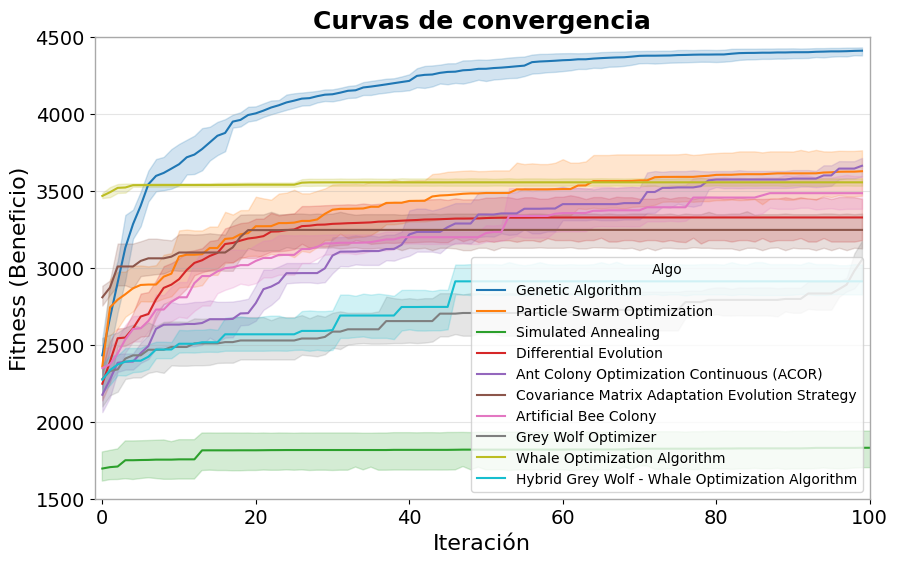

In [23]:
# GSA Convergence plot
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Curvas de convergencia",
              x_label="Iteración",
              y_label="Fitness (Beneficio)",
              x_limit=(-1, 100),
              y_limit=(1500,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence.pdf'),
              fig_size=())

In [35]:
from scipy import stats

# Filtrar el dataframe por cada algoritmo
genetic_algorithm_df = df_history[df_history['Algo'] == 'Genetic Algorithm']
acor_algorithm_df = df_history[df_history['Algo'] == 'Ant Colony Optimization Continuous (ACOR)']

# Calcular la media de 'Revenue' por cada ejecución (Run) para el algoritmo genético
genetic_revenues_mean = genetic_algorithm_df.groupby('Run')['Fitness'].mean().tolist()

# Calcular la media de 'Revenue' por cada ejecución (Run) para el algoritmo ACOR
acor_revenues_mean = acor_algorithm_df.groupby('Run')['Fitness'].mean().tolist()

# Mostrar las listas
print("Genetic Algorithm Revenue Means:", genetic_revenues_mean)
print("ACOR Revenue Means:", acor_revenues_mean)

Genetic Algorithm Revenue Means: [4145.998711723439, 4026.433919456497, 4174.7407553455805, 4168.648426960138, 4190.514872609186]
ACOR Revenue Means: [3221.930543562657, 3092.1996934658923, 3175.4692325854876, 3259.7421323824474, 3187.064052365891]


In [36]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0625


In [37]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 5
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1065. 1112. 1142.  873.  972. 1046.  907.  828.  913. 1355.  731.  130.
  210.  271.  479.  531.  630.  693.  930.  748.  177.  399.  463.  506.
  939.  968. 1038. 1094. 1132. 1161. 1188. 1253. 1309. 1345.  422.  466.
  503.  278.  336.  374.  528.  570. 1070. 1190. 1249. 1288.  559.  613.
  649. 1241.  462.  525.  567. 1276.  898.  998. 1060.], Discrete: [False  True False  True  True  True  True False  True False  True  True
  True  True  True False  True False  True  True  True  True  True  True
  True]


In [25]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/mealpy/ supply_config_gsa


In [26]:
final_supply = Supply.from_yaml(supply_config_file)

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


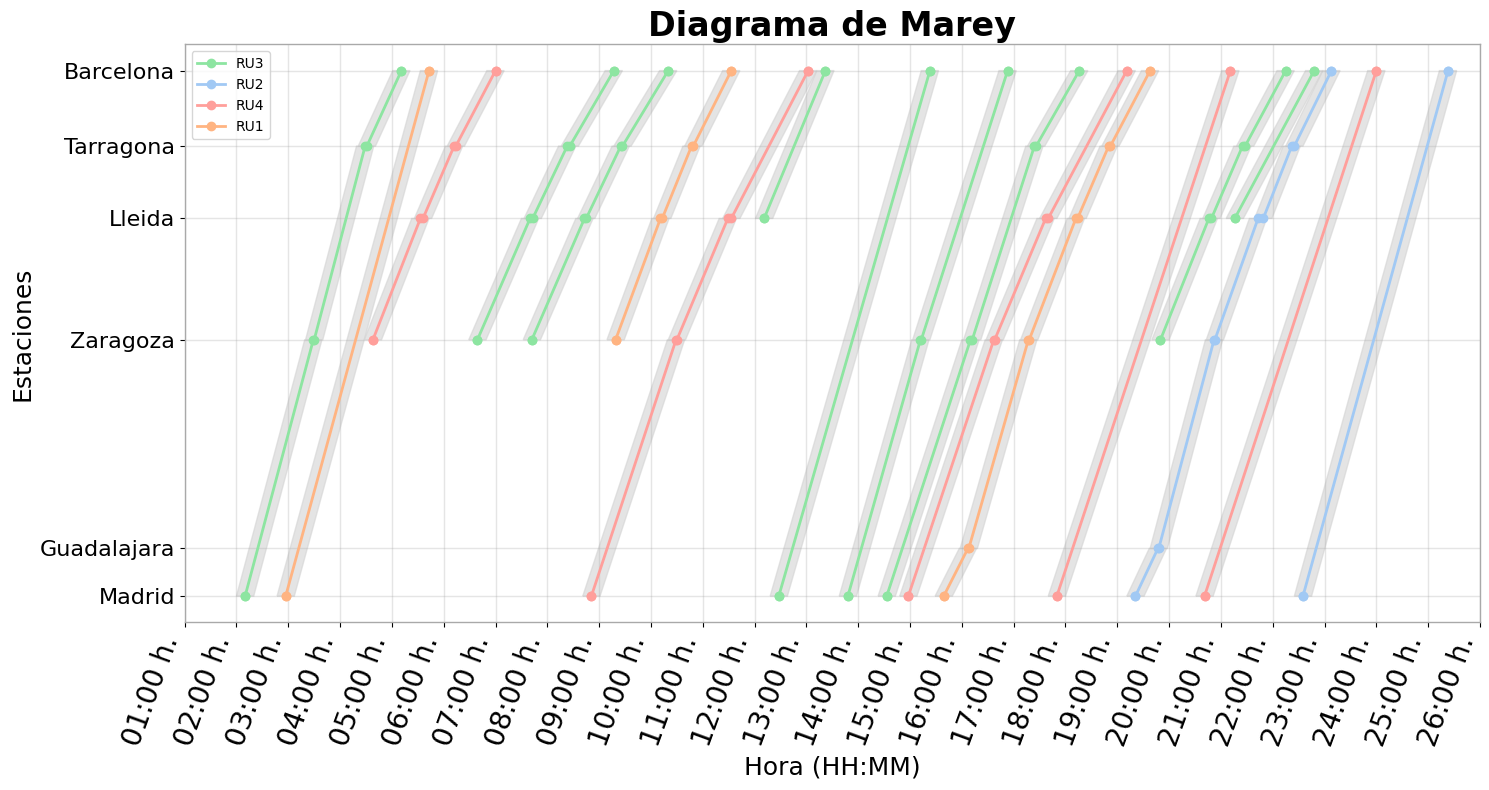

In [27]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [38]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25.yml')

PosixPath('../reports/mealpy/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat